In [1]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from datetime import datetime

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
df_movies = pd.read_csv('./data/ml-latest-small/movies.csv')

In [3]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
df_ratings.shape

(100004, 4)

In [5]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df_movies.shape

(9125, 3)

# 데이터 시각화

In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9125 non-null   int64 
 1   title    9125 non-null   object
 2   genres   9125 non-null   object
dtypes: int64(1), object(2)
memory usage: 214.0+ KB


In [9]:
# checking unique users
print(f"# of Unique Users: {df_ratings['userId'].nunique()}")

# checking number of items
print(f"# of movieId: {df_ratings['movieId'].nunique()}")

# of Unique Users: 671
# of movieId: 9066


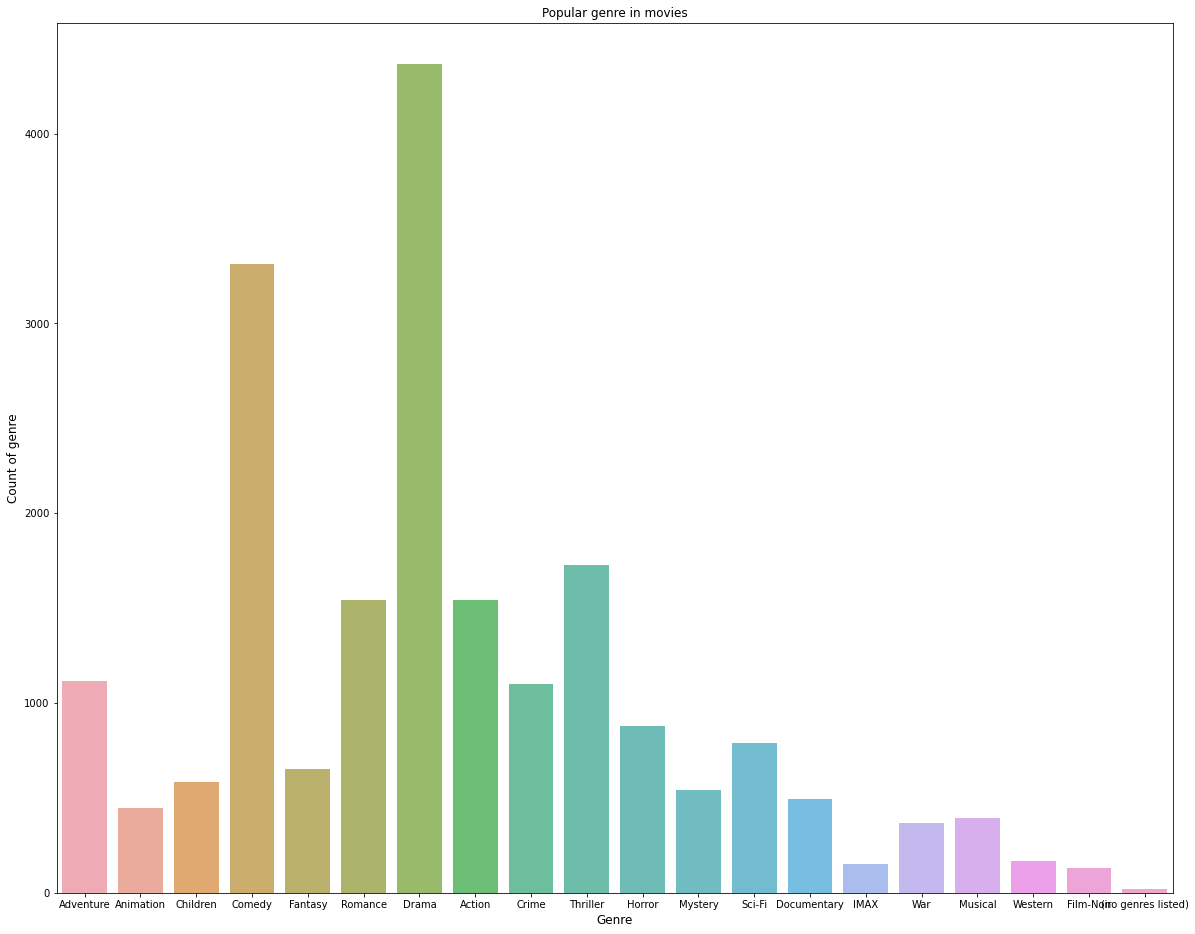

In [10]:
unique_genre_dict = {}
for index, row in df_movies.iterrows():
     
    #여러 장르가 함께 있는 것을 분리하기 위해 '|' 구분자 분리하여 count
    genre_combination = row['genres']
    parsed_genre = genre_combination.split('|')
    
    for genre in parsed_genre:
        if genre in unique_genre_dict:
            unique_genre_dict[genre] += 1
        else:
            unique_genre_dict[genre] = 1

plt.rcParams['figure.figsize'] = [20,16]
sns.barplot(list(unique_genre_dict.keys()), list(unique_genre_dict.values()),
           alpha=0.8)
plt.title('Popular genre in movies')
plt.ylabel('Count of genre', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

# Matrix Factorization using SVD
## with Feature scaling using Standardization

- 원본 user-movie 평점 행렬이 있었음
- 이를 user의 평균 점수를 빼서 R_demeaned 이라는 행렬로 만듬
- 2번의 값을 SVD를 적용해 U, Sigma, Vt 행렬을 구했음
- Sigma 행렬은 현재 0이 포함이 되지 않은 값으로만 구성되어 있음. 이를 대칭행렬로 변환
- 이 과정을 마치고 원본 행렬로 다시 되돌려 놓음

In [11]:
def MatrixFactorizaion(df_ratings, df_movies):
    #사용자-영화 평점 데이터 -> 사용자 별 각 영화 평점 방식
    #사용자-N명, 영화-M개 -> N*M크기의 행렬
    df_movie_features = df_ratings.pivot(
        index='userId',
        columns='movieId',
        values='rating'
    ).fillna(0)
    
    ## Data normalizaiion ##
    #pivot_table 값을 numpy matrix로 만든 것
    R = df_movie_features.to_numpy()
    
    # 각 user들의 rating 평균을 구함
    user_ratings_mean = np.mean(R, axis = 1)
    
    # R_demeaned : 사용자-영화에 대해 사용자 평균 평점을 뺀 것.
    R_demeaned = R - user_ratings_mean.reshape(-1, 1)
    
    M_demeaned = pd.DataFrame(R_demeaned, columns = df_movie_features.columns)
    
    # U 행렬, sigma 행렬, V 전치 행렬을 반환.
    U, sigma, Vt = svds(M_demeaned, k = 50)
    
    # 0이 포함된 대칭행렬로 변환
    sigma = np.diag(sigma)
    
    # U, Sigma, Vt의 내적을 수행하면, 다시 원본 행렬로 복원 + 사용자 평균 rating을 적용 
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    
    #SVD 특이값 분해를 사용해 matrix factorization 기반으로 데이터 변경
    preds_df = pd.DataFrame(all_user_predicted_ratings, columns = df_movie_features.columns)
    
    return preds_df

In [12]:
preds_df = MatrixFactorizaion(df_ratings, df_movies)
preds_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,-0.054239,0.045130,-0.004835,-0.019817,-0.011284,0.041373,-0.007822,-0.017188,0.012246,0.037670,...,-0.005258,-0.005453,0.012369,-0.004991,-0.004639,-0.019055,0.021402,-0.006365,-0.006098,-0.004819
1,0.419835,1.406440,-0.188807,0.156658,0.268032,0.414698,0.052172,0.044728,-0.020198,2.220256,...,-0.005909,-0.003974,-0.012555,-0.003555,-0.002711,-0.071621,-0.016212,0.001047,-0.001468,-0.006577
2,1.345619,0.266505,-0.011962,0.012278,0.079508,0.090960,-0.122094,0.031327,-0.018023,0.141176,...,-0.002647,-0.002364,-0.010153,0.000277,-0.000116,-0.018063,-0.015761,0.010611,0.006792,-0.006357
3,1.133455,1.046982,0.141275,0.081841,-0.339675,-1.484659,-0.263096,-0.169750,-0.021862,1.611664,...,0.020805,0.000410,0.056040,-0.002817,-0.000767,0.159159,0.087519,-0.030854,-0.021279,0.048529
4,1.389578,1.466495,0.605557,-0.029647,0.729380,-0.118539,-0.026017,0.065577,-0.156655,0.307926,...,-0.007422,-0.011810,0.006644,-0.005159,-0.001249,-0.034658,0.016456,0.001710,-0.004166,-0.001864


# All user prediction system

In [13]:
def AllUserPrediction(preds_df, userID, df_movies, df_ratings, num_recommendations=5):

    user_row_number = userID - 1 # UserID starts at 1, not 0
    
    # 최종적으로 만든 pred_df에서 사용자 index에 따라 영화 데이터 정렬 -> 영화 평점이 높은 순으로 정렬
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # 원본 평점 데이터에서 userId에 해당하는 데이터를 뽑아냄
    user_data = df_ratings[df_ratings.userId == (userID)]
    
    # 위에서 뽑은 user_data와 원본 영화 데이터를 합침
    user_full = (user_data.merge(df_movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))
    user_full = user_data.merge(df_movies, on = 'movieId').sort_values(['rating'], ascending=False)
    
    # 원본 영화 데이터에서 사용자가 본 영화 데이터를 제외한 데이터를 추출
    recommendations = df_movies[~df_movies['movieId'].isin(user_full['movieId'])]
    # 사용자의 영화 평점이 높은 순으로 정렬된 데이터와 위 recommendations을 합친다. 
    recommendations = recommendations.merge( pd.DataFrame(sorted_user_predictions).reset_index(), on = 'movieId')
    # 컬럼 이름 바꾸고 정렬해서 return
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :]

    return recommendations

# 330번 user에게 추천해줄 movie list

In [14]:
predictions = AllUserPrediction(preds_df, 330, df_movies, df_ratings, 10)
predictions.head()

,movieId,title,genres,Predictions
246,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,2.190762
487,590,Dances with Wolves (1990),Adventure|Drama|Western,1.924099
294,356,Forrest Gump (1994),Comedy|Drama|Romance|War,1.732990
40,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1.579084
316,380,True Lies (1994),Action|Adventure|Comedy|Romance|Thriller,1.345957


# Generate 'user - time(6hour term)' Matrix

In [15]:
def UserTimeMatrix():
    
    # original dataframe에서 moiveId, rating, drop,
    #데이터 불러오는 부분 최소화 하고 싶어서 이 부분 바꿨어!
    rd = pd.read_csv('./data/ml-latest-small/ratings.csv')
    rd.drop('movieId', axis = 1, inplace = True)
    rd.drop('rating', axis = 1, inplace = True)
    # timestamp2datetime
    rd['Hour_6']=[datetime.fromtimestamp(x).strftime('%H') for x in rd['timestamp']]
    rd.drop('timestamp', axis = 1, inplace = True)
    rd = rd.reindex(columns=['Hour_6','userId'])
    # datetime 기준으로 정렬
    rd = rd.sort_values(by='Hour_6')
    
    # datetime2Hour_6term
    rd.loc[(rd['Hour_6']=="00") | (rd["Hour_6"]=="01") | 
           (rd["Hour_6"]=="02") | (rd["Hour_6"]=="03"),"Hour_6"] = "h1"
    rd.loc[(rd['Hour_6']=="04") | (rd["Hour_6"]=="05") | 
           (rd["Hour_6"]=="06") | (rd["Hour_6"]=="07"),"Hour_6"] = "h2"
    rd.loc[(rd['Hour_6']=="08") | (rd["Hour_6"]=="09") | 
           (rd["Hour_6"]=="10") | (rd["Hour_6"]=="11"),"Hour_6"] = "h3"
    rd.loc[(rd['Hour_6']=="12") | (rd["Hour_6"]=="13") | 
           (rd["Hour_6"]=="14") | (rd["Hour_6"]=="15"),"Hour_6"] = "h4"
    rd.loc[(rd['Hour_6']=="16") | (rd["Hour_6"]=="17") | 
           (rd["Hour_6"]=="18") | (rd["Hour_6"]=="19"),"Hour_6"] = "h5"
    rd.loc[(rd['Hour_6']=="20") | (rd["Hour_6"]=="21") | 
           (rd["Hour_6"]=="22") | (rd["Hour_6"]=="23"),"Hour_6"] = "h6"
    
    rd=rd.drop_duplicates(['userId'], keep='first', ignore_index='True')
    rd = rd.sort_values(by='userId')
    return rd

In [16]:
M1 = UserTimeMatrix()
M1.head()

,Hour_6,userId
472,h3,1
614,h6,2
297,h2,3
223,h1,4
407,h3,5


# Generate 'user - prediction(top 5)' Matrix

In [17]:
def UserPredictionMatrix(df_ratings, df_movies):
    
    user_title = {}
    for i in range(1, df_ratings['userId'].max()+1):
        predictions = AllUserPrediction(preds_df, i, df_movies, df_ratings, 10)
        df = predictions[:5]
        title = df[['title']]
        #title.drop(index='userId')
        title.reset_index(drop=True)
        title.rename(columns = {"title": i}, inplace = True)
        dict_from_df = title.to_dict('list')
        user_title.update(dict_from_df)
    df = pd.DataFrame(user_title)
    df = pd.DataFrame(list(user_title.items()),columns =['userId','title'])
    
    return df

In [18]:
M2 = UserPredictionMatrix(df_ratings, df_movies)
M2.head()

,userId,title
0,1,"[Star Trek II: The Wrath of Khan (1982), Rocky..."
1,2,"[True Lies (1994), Shawshank Redemption, The (..."
2,3,"[Matrix, The (1999), Lord of the Rings: The Fe..."
3,4,"[Beauty and the Beast (1991), Raising Arizona ..."
4,5,"[Men in Black (a.k.a. MIB) (1997), Sleepless i..."


# Merge 'time-user' Matrix and 'user - prediction(top 5)' Matrix

In [19]:
def TimeUserMovieMatrix(M1,M2):
    time_user_movie=pd.merge(M1,M2,on='userId')
    time_user_movie=time_user_movie.sort_values(by='Hour_6', ignore_index='True')
    
    return time_user_movie

In [20]:
M3=TimeUserMovieMatrix(M1,M2)
M3.head()

,Hour_6,userId,title
0,h1,336,"[Shawshank Redemption, The (1994), One Flew Ov..."
1,h1,371,"[Schindler's List (1993), Godfather, The (1972..."
2,h1,369,"[Silence of the Lambs, The (1991), Crimson Tid..."
3,h1,367,[Star Wars: Episode VI - Return of the Jedi (1...
4,h1,365,"[Lord of the Rings: The Two Towers, The (2002)..."


# Enter time and movie name

In [21]:
def Time_MovieName():
    #time=int(input("time: "))
    #movie= [input("movie: ")]
    #이거 입력하기 번거로워서 우선 아무 값 설정해둠!
    time=1
    movie=["Toy Story (1995)"]
    
    if (time>=0 & time<4): time='h1'
    elif (time>=4 & time<8): time='h2'
    elif (time>=8 & time<12): time='h3'
    elif (time>=12 & time<16): time='h4'
    elif (time>=16 & time<20): time='h5'
    elif (time>=20 & time<24): time='h6'
    else: print("error")
   
    return time, movie

# Print the result

In [22]:
#이거는 M1+M2 합쳐진 M3 사용할 때!
def main(M3):
    time, movie=Time_MovieName()
    #이 부분에서 뒤에 시간 조건문만 새로 달았음!
    m = M3["title"].apply(lambda s: len(set(s) & set(movie)) > 0) & (M3["Hour_6"]==time)
    
    #유저 아이디 크기별로 정렬
    M3=M3[m].sort_values(by='userId', ignore_index='True')
    return M3

In [23]:
#만약 M1, M2 미리 안합치고 분리된 채로 쓸 때
'''def main(M1,M2):
    M3 = pd.merge(M1, M2, on="userId")
    M3 = M3.drop_duplicates(["userId"])
    
    time, movie=Time_MovieName()
    #이 부분에서 뒤에 시간 조건문만 새로 달았음!
    m = M3["title"].apply(lambda s: len(set(s) & set(movie)) > 0) & (M3["Hour_6"]==time)
    
    #유저 아이디 크기별로 정렬
    M3=M3[m].sort_values(by='userId', ignore_index='True')
    return M3'''

'def main(M1,M2):\n    M3 = pd.merge(M1, M2, on="userId")\n    M3 = M3.drop_duplicates(["userId"])\n    \n    time, movie=Time_MovieName()\n    #이 부분에서 뒤에 시간 조건문만 새로 달았음!\n    m = M3["title"].apply(lambda s: len(set(s) & set(movie)) > 0) & (M3["Hour_6"]==time)\n    \n    #유저 아이디 크기별로 정렬\n    M3=M3[m].sort_values(by=\'userId\', ignore_index=\'True\')\n    return M3'

In [24]:
pd.set_option('display.max.colwidth', 200)
main(M3)
#main(M1,M2)

,Hour_6,userId,title
0,h1,61,"[Toy Story (1995), Good Will Hunting (1997), Eternal Sunshine of the Spotless Mind (2004), Truman Show, The (1998), Apollo 13 (1995)]"
1,h1,190,"[Fight Club (1999), Blair Witch Project, The (1999), Toy Story (1995), Bug's Life, A (1998), Casino (1995)]"
2,h1,234,"[Back to the Future (1985), Lion King, The (1994), Eternal Sunshine of the Spotless Mind (2004), Toy Story (1995), Dark Knight, The (2008)]"
3,h1,295,"[Toy Story (1995), Groundhog Day (1993), Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Ghost (1990), Aliens (1986)]"
4,h1,394,"[Lord of the Rings: The Return of the King, The (2003), Lord of the Rings: The Two Towers, The (2002), Toy Story (1995), American Beauty (1999), Jurassic Park (1993)]"
5,h1,427,"[Eternal Sunshine of the Spotless Mind (2004), Pianist, The (2002), Royal Tenenbaums, The (2001), High Fidelity (2000), Toy Story (1995)]"
6,h1,523,"[Schindler's List (1993), Back to the Future (1985), Saving Private Ryan (1998), Shrek (2001), Toy Story (1995)]"
7,h1,550,"[Toy Story (1995), Star Wars: Episode IV - A New Hope (1977), Back to the Future (1985), Blade Runner (1982), Usual Suspects, The (1995)]"
8,h1,640,"[Rock, The (1996), Toy Story (1995), Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Phenomenon (1996), Ransom (1996)]"
9,h1,659,"[Toy Story (1995), Babe (1995), Beauty and the Beast (1991), Clear and Present Danger (1994), Interview with the Vampire: The Vampire Chronicles (1994)]"
